# Datamining

In [2]:
SEED = 26062019

test_size = 0.5 

import sys
import numpy as np
import pandas as pd
from sklearn import __version__ as sk_vers
import matplotlib.pyplot as plt
from matplotlib import __version__ as m_vers

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)

Current versions Modules:

Pandas version:		0.24.2
Matplotlib version:	3.1.0
numpy version:		1.16.4
sklearn version:	0.21.2


## Load data

In [3]:
df_bitm = pd.read_csv(r'data/BITM_Cancer_dataset.csv', sep='\t', header=None)
df_chromPos = pd.read_csv(r'data/Train_call.txt', sep='\t', header=0)
print('nr of entries: ', len(df_bitm))

df_bitm.head()

nr of entries:  100


,0,1,2,3,4,5,6,7,8,9,...,2826,2827,2828,2829,2830,2831,2832,2833,2834,2835
0,Array.129,HER2+,0,0,0,0,0,0,0,0,...,2,2,2,2,0,1,1,1,1,1
1,Array.34,HR+,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,Array.67,HR+,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,Array.24,Triple Neg,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
4,Array.22,Triple Neg,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [126]:
class ClinicalInformationRetrieval():
    def __init__(self, df_clinic):
        self.df = df_clinic
        
    def getChrPosition(self, i, offset=-2):
        """
        Specify feature and get corresponding region on chromosome
        Input: 
            i = feature index
        """
        return self.df[['Chromosome', 'Start', 'End']].iloc[i+offset]
    
ch = ClinicalInformationRetrieval(df_chromPos)
print('Test clinical retrieval:\n\n' + str(ch.getChrPosition(9)))


Test clinical retrieval:

Chromosome          1
Start         1676445
End           1703748
Name: 7, dtype: int64


(32, 36, 32)


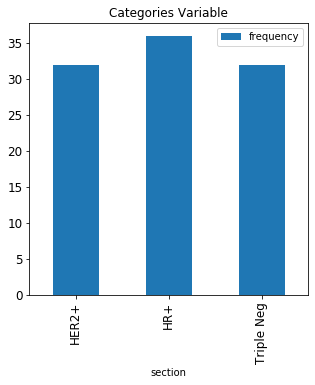

In [3]:
from collections import Counter

labels, values = zip(*Counter(df_bitm[1]).items())
print(values)
df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Categories Variable", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=90)

### Import important modules

In [10]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold
import numpy as np

## Feature Reduction

In [8]:
X = df_bitm[df_bitm.columns[2:]]
y = df_bitm[df_bitm.columns[1]]


## Double Cross Validation

Consists of the following steps:
- hyperparameter tuning
- model selection

In [129]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
#from yellowbrick.model_selection import rfecv
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

models = [
    # Support Vector Machine - 1
    Pipeline([
                ('clf', SVC(gamma='auto', random_state=SEED))
            ]),
    # Naive Bayes - 2
    Pipeline([
                ('clf', MultinomialNB()),
            ]),
    # K Nearest Neighbours - 3
    Pipeline([
                ('clf', KNeighborsClassifier()), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Random Forest - 4
    Pipeline([
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    ]

names = ['SVM', 'Naive Bayes', 'KNN', 'Random Forest']
pal = ['r', 'c', 'b', 'y', 'magenta', 'darkgreen', 'indigo', 'black', 'orange'] 

In [130]:
# large folds -> to ensure enough training & validation data
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from yellowbrick.model_selection import RFECV
import pickle
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import EnsembleVoteClassifier

SEED = 26062019

X = df_bitm[df_bitm.columns[2:]]

# remove negative values
X = X.replace(2, 3)
X = X.replace(1, 2)
X = X.replace(0, 1)
X = X.replace(-1, 0)

y = df_bitm[df_bitm.columns[1]]

enc = preprocessing.LabelEncoder()
y = enc.fit_transform(y)  #['HER2+', 'HR+', 'Triple Neg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)


# Lasso regression ! 
sfm = SelectFromModel(LassoCV(cv=10))
sfm.fit(X_train,y_train)


print('Before Feature Selection: ', len(X_train.columns))
X_train = sfm.transform(X_train) #.shape[1]
print('After Feature Selection: ', len(X_train[0]))

old_f1 = 0
param = 0
best_model = ''

for nr in range(len(models)):
    estimator = models[nr]
    if names[nr] == 'SVM':
        param_grid =  {
                'clf__kernel': ['linear', 'poly', 'sigmoid'], # 'rbf' -> not rbf as it is prone to overfitting!
                'clf__C': [ 0.01, 0.01, 0.1, 1, 10, 100], # 0.01, 0.01, 0.1,
            }
    elif names[nr] == 'Random Forest':
        param_grid =  {
            'clf__max_depth': [5, 10, 20, 30],
            'clf__n_estimators': [10, 100]
            }
    elif names[nr] == 'KNN':
        param_grid = { 
            'clf__leaf_size': [5, 10, 20, 30, 40],
            'clf__n_neighbors': [3, 5, 7, 9]
            }
    elif names[nr] == 'Naive Bayes':
        param_grid = { 
            'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
    kfold_outer = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)
    for i, (train, valid) in enumerate(kfold_outer.split(X_train, y_train)):
        # reset
        
        #kfold_inner = StratifiedKFold(n_splits=3,shuffle=True,random_state=SEED)
        
        X_tr, y_tr, X_valid, y_valid = X_train[train], y_train[train], X_train[valid], y_train[valid]
        grid = GridSearchCV(estimator, param_grid, cv=3, scoring='f1_micro')

        grid.fit(X_tr, y_tr) 
        y_pred = grid.predict(X_valid)
        f1 = f1_score(y_valid, y_pred, average='micro')
        print('F1:', str(f1), 'Best params:', str(grid.best_params_))  # print best hyperparam
        #print(classification_report(y_valid, y_pred, target_names=['1', '2', '3']))
    if f1 > old_f1:
        print('New Best')
        print('Final F1:', str(f1), 'Best params:', str(grid.best_params_))
        pickle.dump(grid, open('models/optimal_model.sav', 'wb'))
        old_f1 = f1
        param = grid.best_params_
        best_model = names[nr]
        
print('Best model:', best_model, ' F1-final:', old_f1, 'Param:', param)    

Before Feature Selection:  2834
After Feature Selection:  40


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.9354838709677419 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
F1: 0.9333333333333333 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: Depreca

F1: 0.9310344827586207 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
New Best
Final F1: 0.9310344827586207 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
F1: 0.8387096774193549 Best params: {'clf__alpha': 1}
F1: 0.7666666666666667 Best params: {'clf__alpha': 1}
F1: 0.896551724137931 Best params: {'clf__alpha': 1}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.6774193548387096 Best params: {'clf__leaf_size': 5, 'clf__n_neighbors': 5}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8000000000000002 Best params: {'clf__leaf_size': 5, 'clf__n_neighbors': 3}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.7931034482758621 Best params: {'clf__leaf_size': 10, 'clf__n_neighbors': 9}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.9032258064516129 Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


F1: 0.8000000000000002 Best params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
F1: 0.896551724137931 Best params: {'clf__max_depth': 10, 'clf__n_estimators': 100}
Best model: SVM  F1-final: 0.9310344827586207 Param: {'clf__C': 0.1, 'clf__kernel': 'linear'}


C:\Users\levrex\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Performance on Validation set

In [131]:
best_model = pickle.load(open('models/optimal_model.sav', 'rb'))
print('Before Feature Selection: ', len(X_test.columns))
X_test_t = sfm.transform(X_test) #.shape[1]
print('After Feature Selection: ', len(X_test_t[0]))
y_pred =  best_model.predict(X_test_t)
f1 = f1_score(y_test, y_pred, average='micro')
print('F1 final:', str(f1), 'Best params:', str(best_model.best_params_))  # print best hyperparam
print(classification_report(y_test, y_pred, target_names=['0', '1', '2']))

Before Feature Selection:  2834
After Feature Selection:  40
F1 final: 1.0 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



Confusion matrix, without normalization
[[3 0 0]
 [0 2 0]
 [0 0 5]]


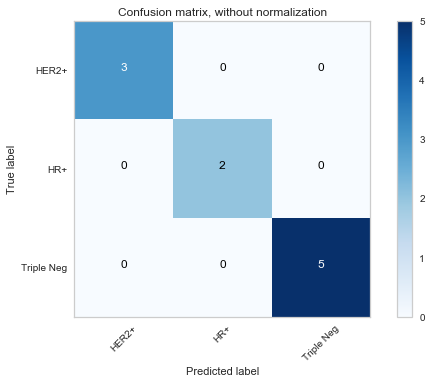

In [137]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("figures/confusion_matrix_validation.png")


cnf_matrix = confusion_matrix(y_test, y_pred,labels=[0,1,2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
ax = plt.gca()
ax.grid(False)
plot_confusion_matrix(cnf_matrix, classes=['HER2+', 'HR+', 'Triple Neg'],
                      title='Confusion matrix, without normalization')

## Determine best regions

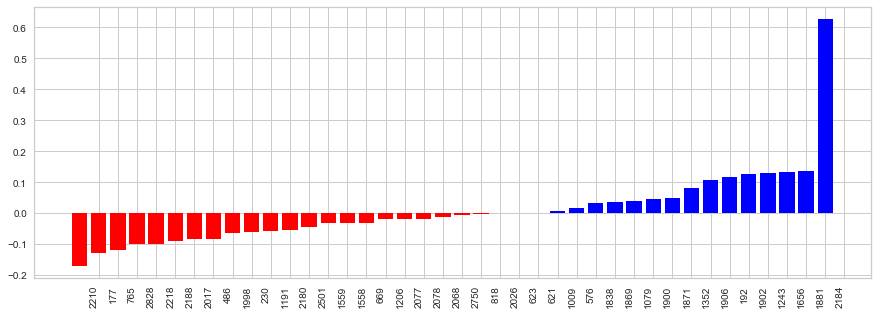

<Figure size 576x396 with 0 Axes>

In [138]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.best_estimator_.named_steps['clf'].coef_[1] #.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=90, ha='right')
    plt.savefig("figures/coef_plot_biomarkers.png")
    plt.show()
    
    d = {'id' : feature_names, 'coef': coef}
    df = pd.DataFrame(data=d)
    return df

# Retrieve features from initial fold features
offset = 2
df_coef = plot_coefficients(best_model, [i-offset for i in list(X_test[X_test.columns[sfm.get_support()]].columns)])

In [134]:
df_coef['Chromosome'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[0])
df_coef['Start'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[1])
df_coef['End'] = df_coef['id'].apply(lambda x: ch.getChrPosition(x)[2])
df_coef.head()

,id,coef,Chromosome,Start,End
0,177,-0.127391,1,120405944,120737345
1,192,0.117243,1,146581869,146634734
2,230,-0.060090,1,193652057,199041703
3,486,-0.084038,3,193425674,193467200
4,576,0.015525,4,93240865,100160841


In [135]:
df_coef.sort_values('coef').to_csv(r'results/SVM_biomarkers_coefs.csv', index=False)